In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
# Load the dataset from Google Drive into a pandas DataFrame
df_dl = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/GitHub_ToChair/FilteredDataSetForExp_001.csv')

In [3]:
df_dl.shape

(325420, 2)

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Step 2 & 3: Tokenize and convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_dl['consumer_complaint_narrative'])
sequences = tokenizer.texts_to_sequences(df_dl['consumer_complaint_narrative'])

# Step 4: Determine maximum sequence length (e.g., based on mean + 2 * std or a percentile)
# For simplicity, let's use a fixed value or calculate a percentile
sequence_lengths = [len(seq) for seq in sequences]
max_sequence_length = int(np.percentile(sequence_lengths, 95)) # Using 95th percentile

# Step 5: Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Step 6 & 7: Encode hierarchical labels
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(df_dl['hierarchical_label'])

# Step 8: One-hot encode labels
one_hot_labels = to_categorical(integer_encoded_labels)

# Step 9: Split data into training and testing sets
X_train_padded, X_test_padded, y_train_one_hot, y_test_one_hot = train_test_split(
    padded_sequences, one_hot_labels, test_size=0.2, random_state=42, stratify=one_hot_labels)

print("Padded sequences shape:", padded_sequences.shape)
print("One-hot encoded labels shape:", one_hot_labels.shape)
print("X_train_padded shape:", X_train_padded.shape)
print("X_test_padded shape:", X_test_padded.shape)
print("y_train_one_hot shape:", y_train_one_hot.shape)
print("y_test_one_hot shape:", y_test_one_hot.shape)

Padded sequences shape: (325420, 479)
One-hot encoded labels shape: (325420, 54)
X_train_padded shape: (260336, 479)
X_test_padded shape: (65084, 479)
y_train_one_hot shape: (260336, 54)
y_test_one_hot shape: (65084, 54)


### Evaluation Metrics: Hierarchical Precision, Hierarchical Recall, Hierarchical F1-score

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Function to split hierarchical labels into product and sub-product
def split_hierarchical_label(label):
    if '::' in label:
        return label.split('::')
    else:
        return [label, 'None'] # Handle cases with no sub-product

# Function to calculate hierarchical metrics
def hierarchical_metrics(y_true, y_pred):
    product_true = [split_hierarchical_label(label)[0] for label in y_true]
    sub_product_true = [split_hierarchical_label(label)[1] for label in y_true]
    product_pred = [split_hierarchical_label(label)[0] for label in y_pred]
    sub_product_pred = [split_hierarchical_label(label)[1] for label in y_pred]

    # Calculate metrics at the product level
    product_precision = precision_score(product_true, product_pred, average='weighted', zero_division=0)
    product_recall = recall_score(product_true, product_pred, average='weighted', zero_division=0)
    product_f1 = f1_score(product_true, product_pred, average='weighted', zero_division=0)

    # Calculate metrics at the sub-product level (only for non-None sub-products)
    # We need to filter for cases where both true and predicted sub-products are not 'None'
    valid_sub_product_true = [sub for i, sub in enumerate(sub_product_true) if sub != 'None' and sub_product_pred[i] != 'None']
    valid_sub_product_pred = [sub for i, sub in enumerate(sub_product_pred) if sub != 'None' and sub_product_true[i] != 'None']


    sub_product_precision = precision_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0
    sub_product_recall = recall_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0
    sub_product_f1 = f1_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0


    # A simple way to combine scores (can be weighted based on importance)
    # Here, we'll just average them
    hierarchical_precision = (product_precision + sub_product_precision) / 2
    hierarchical_recall = (product_recall + sub_product_recall) / 2
    hierarchical_f1 = (product_f1 + sub_product_f1) / 2

    return {
        'product_precision': product_precision,
        'product_recall': product_recall,
        'product_f1': product_f1,
        'sub_product_precision': sub_product_precision,
        'sub_product_recall': sub_product_recall,
        'sub_product_f1': sub_product_f1,
        'hierarchical_precision': hierarchical_precision,
        'hierarchical_recall': hierarchical_recall,
        'hierarchical_f1': hierarchical_f1
    }


### LSTM Model

In [5]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add the Embedding layer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100 # Choose an appropriate embedding size
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer)

# Add the LSTM layer
lstm_layer = LSTM(units=128)(embedding_layer) # Choose an appropriate number of units

# Add Dense layers for classification
# The number of units in the final dense layer should be equal to the number of unique hierarchical labels
num_hierarchical_labels = one_hot_labels.shape[1]
dense_layer = Dense(units=64, activation='relu')(lstm_layer)
output_layer = Dense(units=num_hierarchical_labels, activation='softmax')(dense_layer)

# Create the Keras Model
model_lstm = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 479)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 479, 100)       │     6,478,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │         3,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,607,814 (25.21 MB)

 Trainable params: 6,607,814 (25.21 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile the model
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# Train the model
history_lstm = model_lstm.fit(X_train_padded, y_train_one_hot,
                    epochs=15, # Using 15 epochs
                    batch_size=64, # Using batch size of 64
                    validation_data=(X_test_padded, y_test_one_hot)) # Using test set for validation

Epoch 1/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 147s 35ms/step - accuracy: 0.7371 - loss: 1.3381 - val_accuracy: 0.8088 - val_loss: 0.7954
Epoch 2/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 119s 29ms/step - accuracy: 0.8183 - loss: 0.7348 - val_accuracy: 0.8409 - val_loss: 0.6145
Epoch 3/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 120s 30ms/step - accuracy: 0.8504 - loss: 0.5632 - val_accuracy: 0.8527 - val_loss: 0.5603
Epoch 4/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 119s 29ms/step - accuracy: 0.8666 - loss: 0.4928 - val_accuracy: 0.8531 - val_loss: 0.5560
Epoch 5/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 119s 29ms/step - accuracy: 0.8772 - loss: 0.4397 - val_accuracy: 0.8533 - val_loss: 0.5617
Epoch 6/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 119s 29ms/step - accuracy: 0.8896 - loss: 0.3889 - val_accuracy: 0.8506 - val_loss: 0.5815
Epoch 7/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 118s 29ms/step - accuracy: 0.9014 - loss: 0.3499 - val_accuracy: 0.8485 - val_loss: 0.5988
Epoch 8/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 119s 29ms/step - accuracy: 

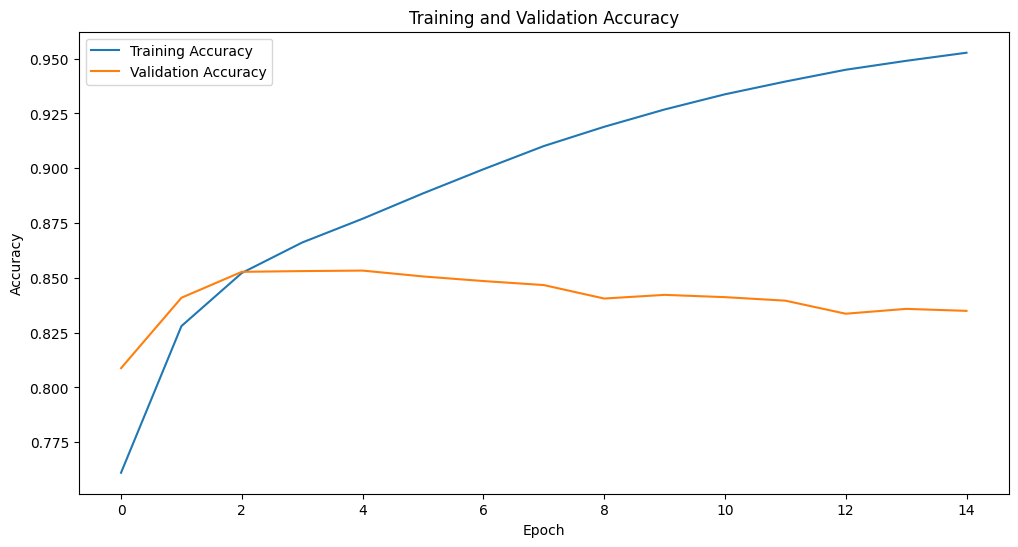

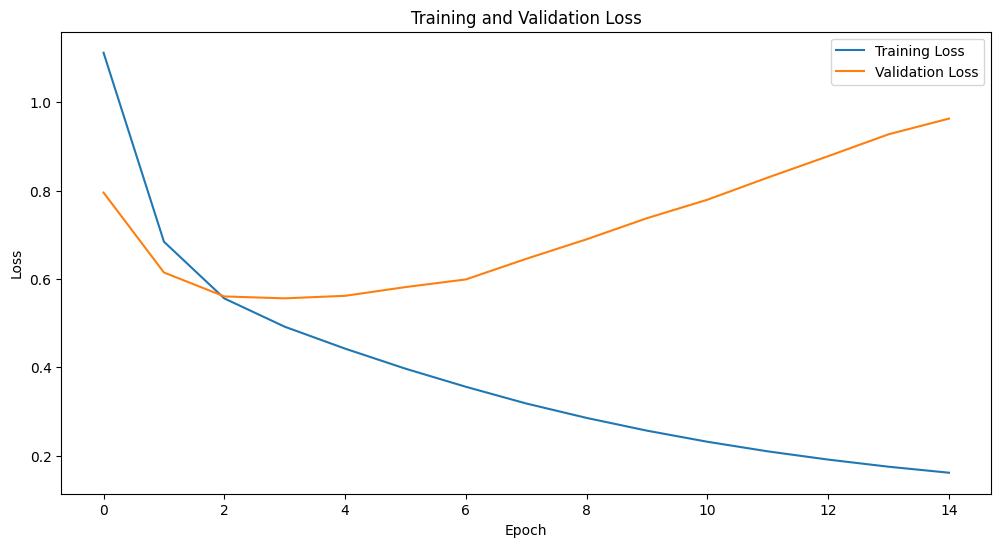

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Make predictions on the test set
y_pred_one_hot = model_lstm.predict(X_test_padded)

# Convert one-hot encoded predictions back to class labels
y_pred_integer_encoded = np.argmax(y_pred_one_hot, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_integer_encoded)

# Convert one-hot encoded true labels back to class labels
y_test_integer_encoded = np.argmax(y_test_one_hot, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_integer_encoded)

# Calculate hierarchical metrics
metrics = hierarchical_metrics(y_test_labels, y_pred_labels)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (LSTM Model):")
print(f"  Product Precision: {metrics['product_precision']:.4f}")
print(f"  Product Recall:    {metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics['hierarchical_f1']:.4f}")

2034/2034 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step

Hierarchical Evaluation Metrics (LSTM Model):
  Product Precision: 0.8719
  Product Recall:    0.8806
  Product F1-score:  0.8749
  Sub-product Precision: 0.8413
  Sub-product Recall:    0.8524
  Sub-product F1-score:  0.8461
  Hierarchical Precision: 0.8566
  Hierarchical Recall:    0.8665
  Hierarchical F1-score:  0.8605


### Bidirectional LSTM

In [12]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout
from tensorflow.keras.models import Model
import numpy as np  # in case it's not already imported

# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add the Embedding layer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # Choose an appropriate embedding size
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_sequence_length,
    mask_zero=True  # helps LSTM ignore padded tokens
)(input_layer)

# Add the Bidirectional LSTM layer
# Note: units is per-direction. The concatenated output size becomes 2 * units.
bilstm_layer = Bidirectional(LSTM(units=128))(embedding_layer)

# (Optional) regularization
dense_prelayer = Dropout(0.3)(bilstm_layer)

# Add Dense layers for classification
num_hierarchical_labels = one_hot_labels.shape[1]
dense_layer = Dense(units=64, activation='relu')(dense_prelayer)
output_layer = Dense(units=num_hierarchical_labels, activation='softmax')(dense_layer)

# Create the Keras Model
model_bilstm = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model_bilstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 479)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 479, 100)  │  6,478,800 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 479)       │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    234,496 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 54)        │      3,510 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,733,254 (25.69 MB)

 Trainable params: 6,733,254 (25.69 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [14]:
# Train the model
history_bilstm = model_bilstm.fit(
    X_train_padded, y_train_one_hot,
    epochs=15,               # Using 15 epochs
    batch_size=64,           # Using batch size of 64
    validation_data=(X_test_padded, y_test_one_hot)  # Using test set for validation
)


Epoch 1/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 188s 46ms/step - accuracy: 0.7896 - loss: 0.9482 - val_accuracy: 0.8408 - val_loss: 0.6065
Epoch 2/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 183s 45ms/step - accuracy: 0.8475 - loss: 0.5772 - val_accuracy: 0.8536 - val_loss: 0.5510
Epoch 3/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 183s 45ms/step - accuracy: 0.8637 - loss: 0.4974 - val_accuracy: 0.8570 - val_loss: 0.5307
Epoch 4/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 182s 45ms/step - accuracy: 0.8793 - loss: 0.4302 - val_accuracy: 0.8576 - val_loss: 0.5338
Epoch 5/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 184s 45ms/step - accuracy: 0.8921 - loss: 0.3734 - val_accuracy: 0.8555 - val_loss: 0.5591
Epoch 6/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 183s 45ms/step - accuracy: 0.9058 - loss: 0.3242 - val_accuracy: 0.8531 - val_loss: 0.5912
Epoch 7/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 186s 46ms/step - accuracy: 0.9170 - loss: 0.2834 - val_accuracy: 0.8522 - val_loss: 0.6293
Epoch 8/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 184s 45ms/step - accuracy: 

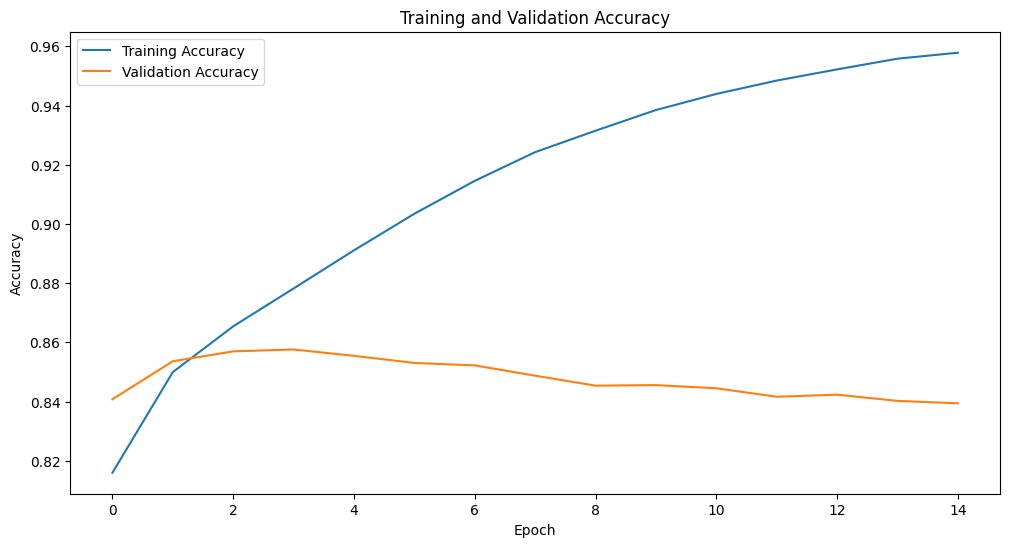

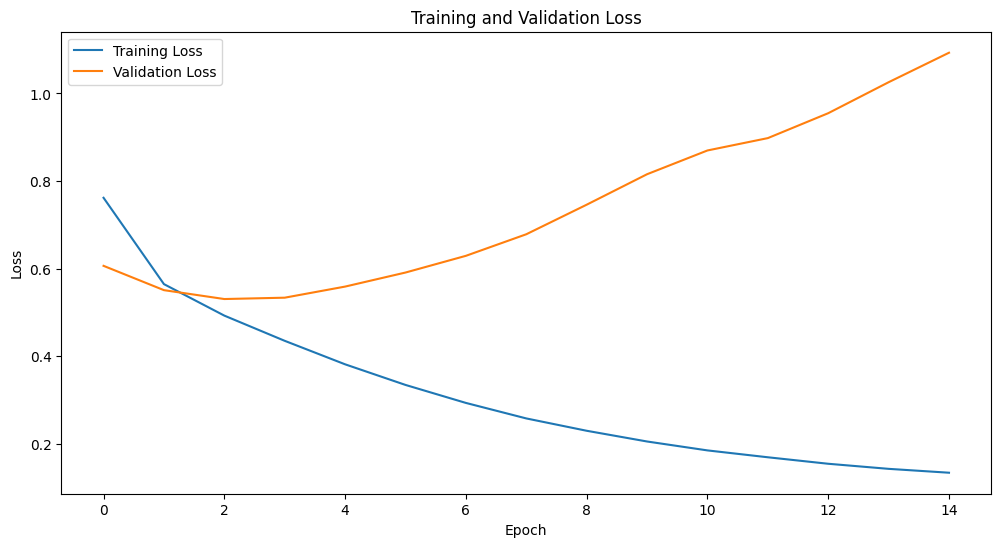

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_bilstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Make predictions on the test set
y_pred_one_hot = model_bilstm.predict(X_test_padded)

# Convert one-hot encoded predictions back to class labels
y_pred_integer_encoded = np.argmax(y_pred_one_hot, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_integer_encoded)

# Convert one-hot encoded true labels back to class labels
y_test_integer_encoded = np.argmax(y_test_one_hot, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_integer_encoded)

# Calculate hierarchical metrics
metrics = hierarchical_metrics(y_test_labels, y_pred_labels)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (BiLSTM Model):")
print(f"  Product Precision: {metrics['product_precision']:.4f}")
print(f"  Product Recall:    {metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics['hierarchical_f1']:.4f}")

2034/2034 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step

Hierarchical Evaluation Metrics (BiLSTM Model):
  Product Precision: 0.8795
  Product Recall:    0.8847
  Product F1-score:  0.8813
  Sub-product Precision: 0.8531
  Sub-product Recall:    0.8570
  Sub-product F1-score:  0.8542
  Hierarchical Precision: 0.8663
  Hierarchical Recall:    0.8708
  Hierarchical F1-score:  0.8678


### CNN-1D

In [17]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the input layer
input_layer_cnn = Input(shape=(max_sequence_length,))

# Add the Embedding layer (reuse vocab_size and embedding_dim from previous steps)
embedding_layer_cnn = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer_cnn)

# Add the 1D Convolutional layer
# Choose appropriate filter size and number of filters
conv1d_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer_cnn)

# Add Global Max Pooling layer to reduce dimensionality
pooling_layer = GlobalMaxPooling1D()(conv1d_layer)

# Add Dense layers for classification
# The number of units in the final dense layer should be equal to the number of unique hierarchical labels
num_hierarchical_labels = one_hot_labels.shape[1]
dense_layer_cnn = Dense(units=64, activation='relu')(pooling_layer)
output_layer_cnn = Dense(units=num_hierarchical_labels, activation='softmax')(dense_layer_cnn)

# Create the Keras Model
model_cnn = Model(inputs=input_layer_cnn, outputs=output_layer_cnn)

# Compile the model
model_cnn.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Print the model summary
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 479)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 479, 100)       │     6,478,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 475, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 54)             │         3,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,554,694 (25.00 MB)

 Trainable params: 6,554,694 (25.00 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the CNN-1D model
history_cnn = model_cnn.fit(
    X_train_padded, y_train_one_hot,
    epochs=15,               # Using 15 epochs
    batch_size=64,           # Using batch size of 64
    validation_data=(X_test_padded, y_test_one_hot)  # Using test set for validation
)

Epoch 1/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - accuracy: 0.8087 - loss: 0.8505 - val_accuracy: 0.8537 - val_loss: 0.5546
Epoch 2/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8648 - loss: 0.4998 - val_accuracy: 0.8586 - val_loss: 0.5261
Epoch 3/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8839 - loss: 0.4121 - val_accuracy: 0.8592 - val_loss: 0.5291
Epoch 4/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9041 - loss: 0.3328 - val_accuracy: 0.8554 - val_loss: 0.5547
Epoch 5/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9237 - loss: 0.2608 - val_accuracy: 0.8521 - val_loss: 0.6235
Epoch 6/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9397 - loss: 0.2048 - val_accuracy: 0.8486 - val_loss: 0.6964
Epoch 7/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9515 - loss: 0.1634 - val_accuracy: 0.8396 - val_loss: 0.8155
Epoch 8/15
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9576 -

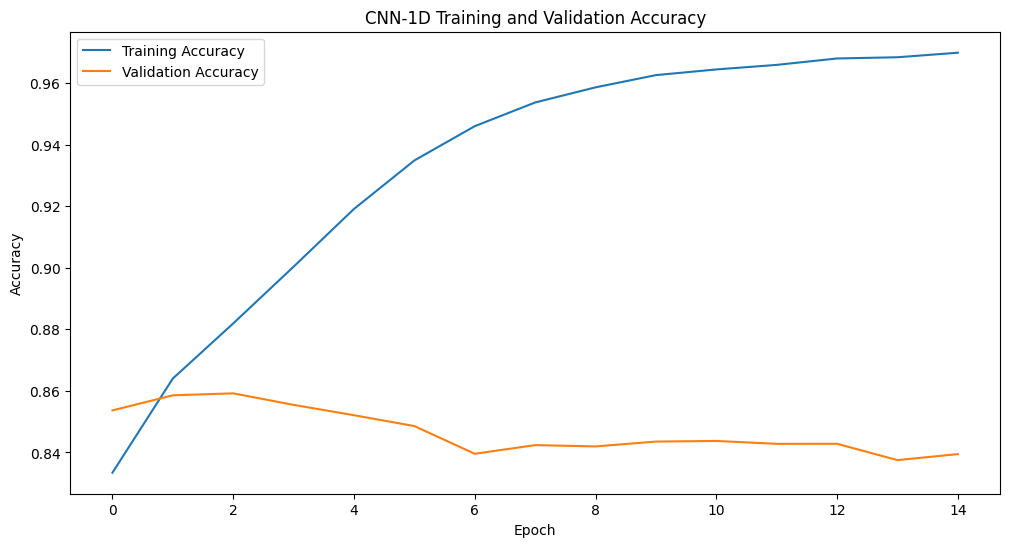

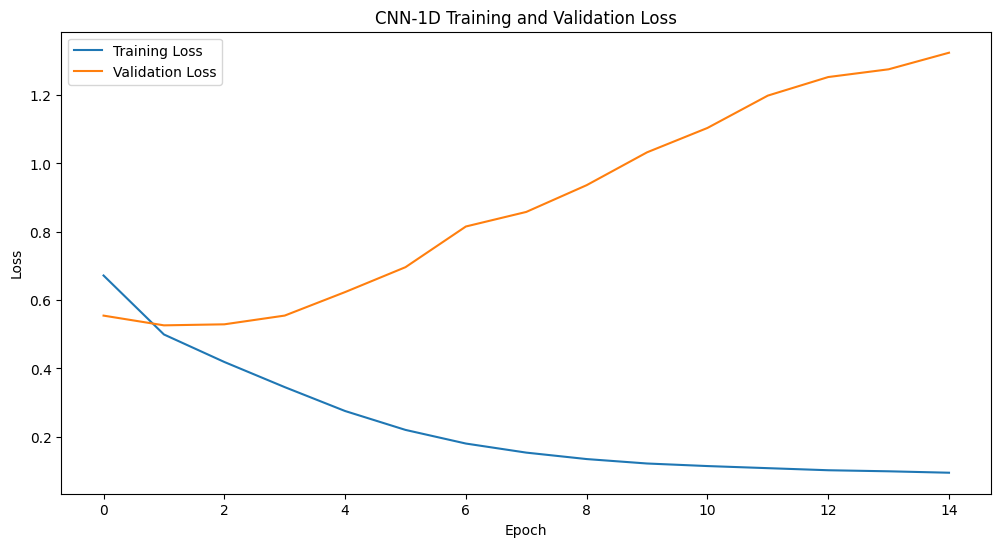

In [19]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy for CNN-1D
plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-1D Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss for CNN-1D
plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN-1D Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Make predictions on the test set using CNN-1D model
y_pred_one_hot_cnn = model_cnn.predict(X_test_padded)

# Convert one-hot encoded predictions back to class labels
y_pred_integer_encoded_cnn = np.argmax(y_pred_one_hot_cnn, axis=1)
y_pred_labels_cnn = label_encoder.inverse_transform(y_pred_integer_encoded_cnn)

# We already have y_test_labels from the previous evaluation
# Convert one-hot encoded true labels back to class labels
y_test_integer_encoded = np.argmax(y_test_one_hot, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_integer_encoded)


# Calculate hierarchical metrics for CNN-1D
metrics_cnn = hierarchical_metrics(y_test_labels, y_pred_labels_cnn)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (CNN-1D Model):")
print(f"  Product Precision: {metrics_cnn['product_precision']:.4f}")
print(f"  Product Recall:    {metrics_cnn['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics_cnn['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics_cnn['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics_cnn['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics_cnn['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics_cnn['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics_cnn['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics_cnn['hierarchical_f1']:.4f}")

2034/2034 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

Hierarchical Evaluation Metrics (CNN-1D Model):
  Product Precision: 0.8773
  Product Recall:    0.8842
  Product F1-score:  0.8791
  Sub-product Precision: 0.8515
  Sub-product Recall:    0.8554
  Sub-product F1-score:  0.8524
  Hierarchical Precision: 0.8644
  Hierarchical Recall:    0.8698
  Hierarchical F1-score:  0.8658
